# 🤖 Model Training & Evaluation — ML vs ANN (Interview‑Ready)

This notebook is a **complete, end‑to‑end classification pipeline** using a **customer‑level feature table**.
It compares **classical ML models** with an **ANN (MLP)** and includes:

- ROC & **Precision–Recall curves**
- **Threshold tuning** (optimize recall with optional precision constraint)
- **Feature importance** (Random Forest + permutation importance)
- Clear explanations and **interview questions at every step**

**Dataset expectation (already engineered):**
- Numeric features (RFM + engineered metrics)
- One‑hot country columns (e.g., `Country_France`)
- Target: `is_churned` (0/1)


## 0️⃣ Imports & Configuration (Interview focus: reproducibility)

**Interview angle:** How do you make experiments reproducible and easy to rerun?
- Centralize paths and constants
- Fix random seeds
- Keep all imports at the top


In [ ]:
# pip install --only-binary=:all: numpy==1.26.4 pandas==2.2.1 scikit-learn==1.4.2 joblib==1.3.2

  Using cached pandas-2.2.1-cp311-cp311-win_amd64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 3.0.0
    Uninstalling pandas-3.0.0:
      Successfully uninstalled pandas-3.0.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# pip install streamlit==1.32.2 plotly==5.20.0 matplotlib seaborn openpyxl ucimlrepo ipykernel notebook jupyter

In [2]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.inspection import permutation_importance

# --------------------
# Configuration
# --------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Update this path if needed
DATA_PATH = Path(r"C:\Users\abhin\ai-systems-foundations\DeepLearningProject\data\processed\customer_features_v2.csv")
TARGET = "is_churned"

plt.rcParams['figure.dpi'] = 120


### Interview mini‑Q (Step 0)
1. Why fix a random seed?
2. Why avoid hard‑coding paths inside functions?
3. What reproducibility issues do notebooks usually have?


## 1️⃣ Load & Validate the Feature Table (Interview focus: schema checks)

This is a **feature table**, not transaction data.  
So we **do not expect** `InvoiceDate`, `Quantity`, or `UnitPrice`.


In [3]:
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.astype(str).str.strip()

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Columns: {df.columns.tolist()}")

# Clean target to binary 0/1
df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce').fillna(0).astype(int)

# Drop ID-like columns (important to avoid leakage)
drop_cols = [c for c in ['CustomerID'] if c in df.columns]
X = df.drop(columns=[TARGET] + drop_cols)
y = df[TARGET]

print('Shape:', df.shape)
print('X shape:', X.shape, 'y shape:', y.shape)
print('Target distribution:\n', y.value_counts())
df.head()


Shape: (3588, 23)
X shape: (3588, 21) y shape: (3588,)
Target distribution:
 is_churned
0    1936
1    1652
Name: count, dtype: int64


,CustomerID,Frequency,Monetary,avg_basket_value,avg_items_per_invoice,Recency,Tenure,gap_mean,gap_median,gap_std,...,is_churned,Country_Belgium,Country_France,Country_Germany,Country_Netherlands,Country_Other,Country_Portugal,Country_Spain,Country_Switzerland,Country_United Kingdom
0,12346,1,77556.46,77556.46,74285.0,235,400,0.0,0.0,0.0,...,1,False,False,False,False,False,False,False,False,True
1,12347,1,4114.18,4114.18,2418.0,39,274,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
2,12348,1,1709.40,1709.40,2497.0,158,189,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
3,12349,1,2671.14,2671.14,993.0,317,181,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
4,12352,1,1905.61,1905.61,442.0,172,130,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False


### Interview mini‑Q (Step 1)
1. Why should `CustomerID` never be used as a feature?
2. Why coerce the target to integer?
3. How do you detect schema drift in production?


## 2️⃣ Train/Test Split (Interview focus: evaluation integrity)

We stratify by the target to preserve churn ratio.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (2691, 21) Test: (897, 21)


### Interview mini‑Q (Step 2)
1. Why stratify in classification problems?
2. When would you use time‑based splits instead?


## 3️⃣ Preprocessing (Interview focus: scaling & leakage)

All features are numeric (one‑hot already applied).
- Median imputation for robustness
- Standard scaling for LR, SVM, ANN


In [5]:
numeric_cols = X_train.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols)
    ],
    remainder='drop'
)


### Interview mini‑Q (Step 3)
1. Why is scaling critical for ANN and SVM?
2. Why are tree models less sensitive to scaling?


## 4️⃣ Models (ML + ANN)

We compare:
- Logistic Regression (baseline)
- SVM (non‑linear margin)
- Gradient Boosting
- Random Forest
- ANN (MLPClassifier)


In [6]:
models = {
    'LogReg': LogisticRegression(max_iter=3000, class_weight='balanced', random_state=RANDOM_STATE),
    'SVM_RBF': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    'GradBoost': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(
        n_estimators=500, random_state=RANDOM_STATE, class_weight='balanced_subsample', n_jobs=-1
    ),
    'ANN_MLP': MLPClassifier(
        hidden_layer_sizes=(128, 64), activation='relu', alpha=0.001,
        batch_size=64, learning_rate_init=0.001, max_iter=600,
        random_state=RANDOM_STATE, early_stopping=True
    )
}

pipelines = {name: Pipeline([('prep', preprocess), ('model', mdl)]) for name, mdl in models.items()}
pipelines.keys()


dict_keys(['LogReg', 'SVM_RBF', 'GradBoost', 'RandomForest', 'ANN_MLP'])

### Interview mini‑Q (Step 4)
1. Why always keep preprocessing inside a Pipeline?
2. Why use early stopping for ANN?


## 5️⃣ Evaluation Helpers

We centralize metrics to keep evaluation consistent.


In [7]:
def score_binary(y_true, y_pred, y_prob):
    return {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
        'roc_auc': float(roc_auc_score(y_true, y_prob))
    }


## 6️⃣ Train Models & Compare Metrics

We rank models by ROC‑AUC (robust for imbalance).


In [8]:
results = []
artifacts = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    prob = pipe.predict_proba(X_test)[:, 1]

    metrics = score_binary(y_test, pred, prob)
    metrics['model'] = name
    results.append(metrics)

    artifacts[name] = {
        'pipe': pipe,
        'pred': pred,
        'prob': prob,
        'cm': confusion_matrix(y_test, pred)
    }

results_df = pd.DataFrame(results).set_index('model').sort_values('roc_auc', ascending=False)
results_df


,accuracy,precision,recall,f1,roc_auc
model,,,,,
GradBoost,0.693423,0.675127,0.644068,0.659232,0.751421
ANN_MLP,0.686734,0.681319,0.600484,0.638353,0.750040
RandomForest,0.671126,0.653646,0.607748,0.629862,0.745915
LogReg,0.686734,0.665829,0.641646,0.653514,0.745052
SVM_RBF,0.673356,0.635135,0.682809,0.658110,0.744512


### Interview mini‑Q (Step 6)
1. Why is ROC‑AUC preferred over accuracy for churn?
2. When would Precision–Recall AUC be more informative?


## 7️⃣ Confusion Matrices (Interview focus: error analysis)


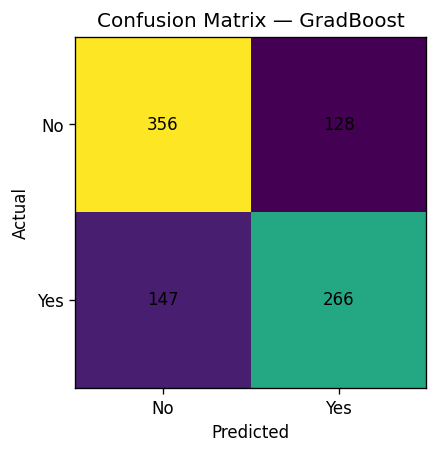

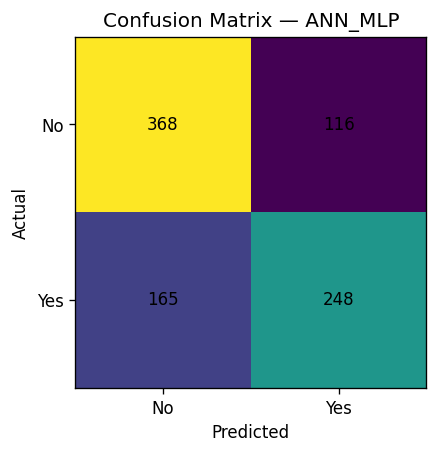

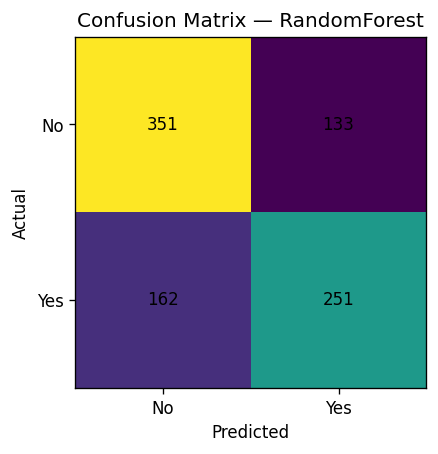

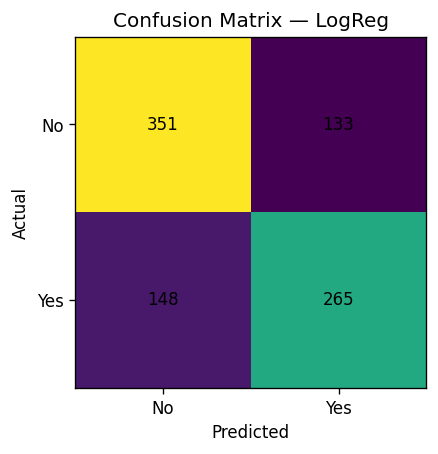

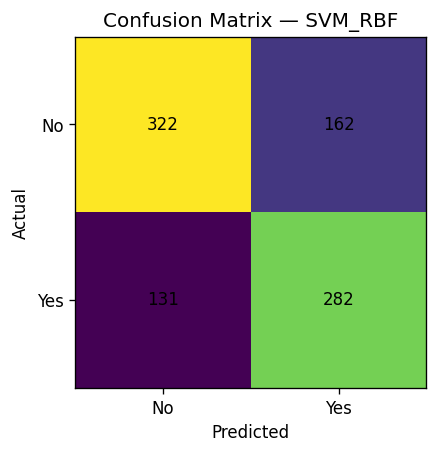

In [9]:
def plot_cm(cm, title):
    fig = plt.figure(figsize=(4.8, 3.8))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.yticks([0, 1], ['No', 'Yes'])
    plt.show()

for name in results_df.index:
    plot_cm(artifacts[name]['cm'], f'Confusion Matrix — {name}')


## 8️⃣ ROC Curves (Model Comparison)


<Figure size 900x660 with 0 Axes>

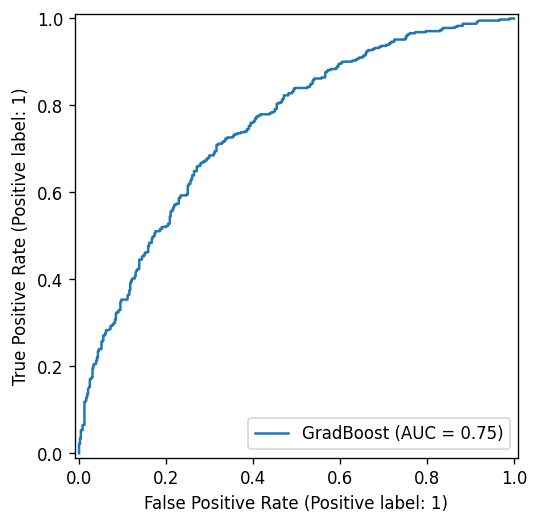

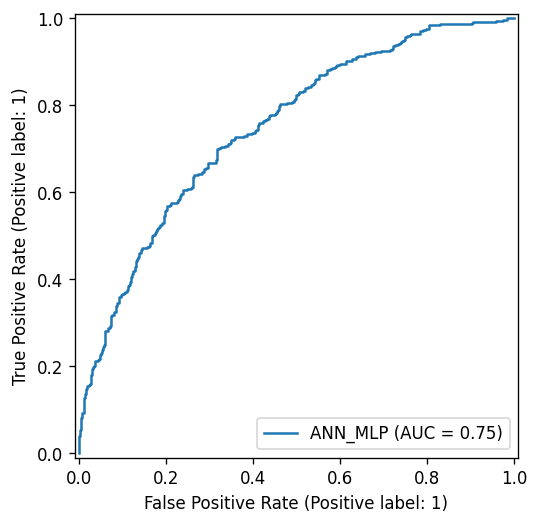

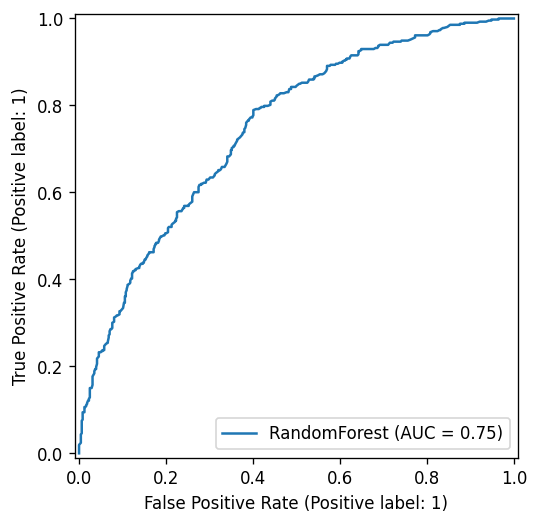

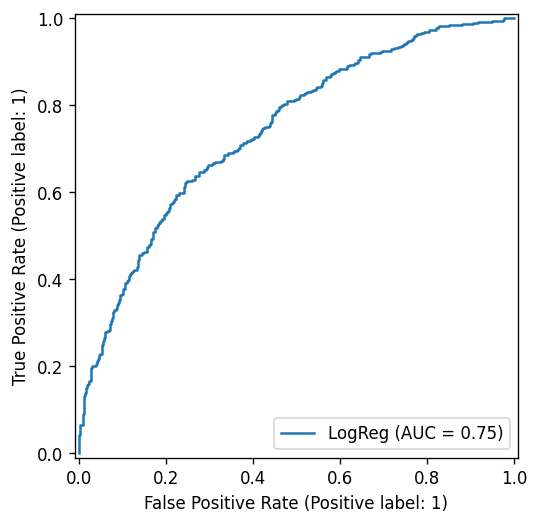

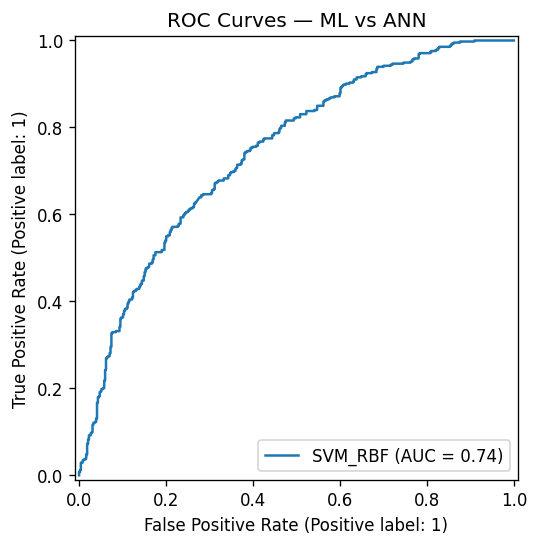

In [10]:
plt.figure(figsize=(7.5, 5.5))
for name in results_df.index:
    RocCurveDisplay.from_predictions(y_test, artifacts[name]['prob'], name=name)
plt.title('ROC Curves — ML vs ANN')
plt.show()


## 9️⃣ Precision–Recall Curves (Critical for Imbalance)


<Figure size 900x660 with 0 Axes>

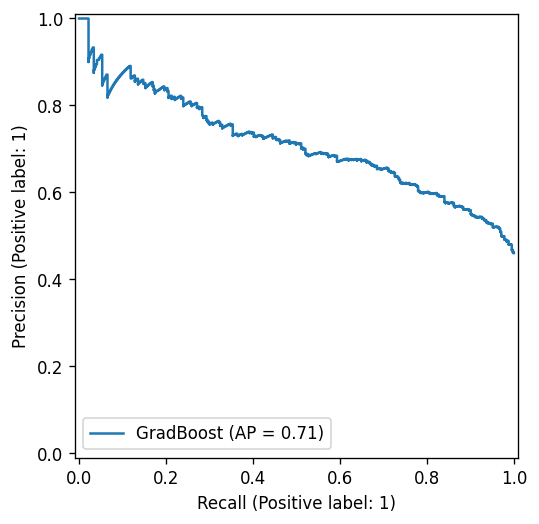

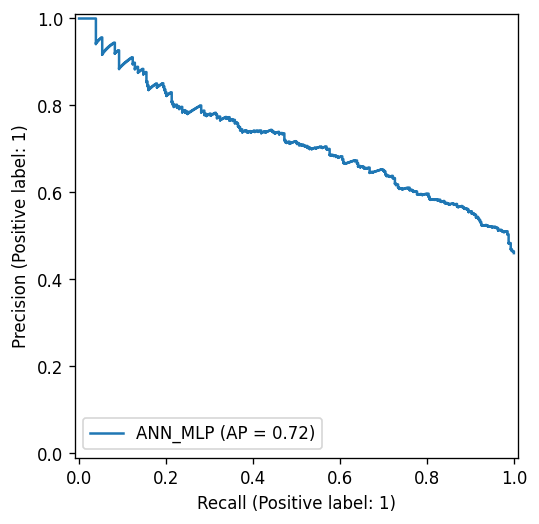

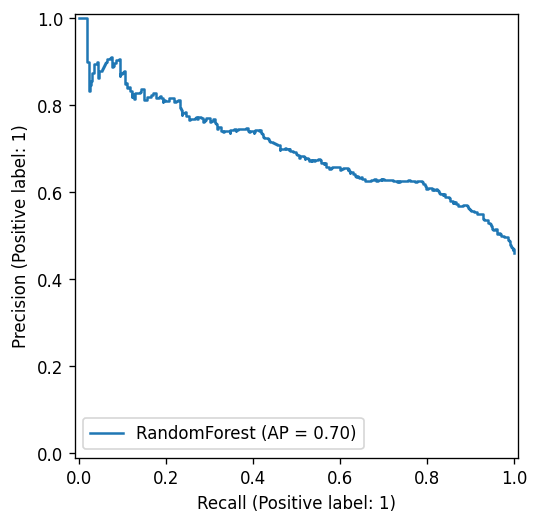

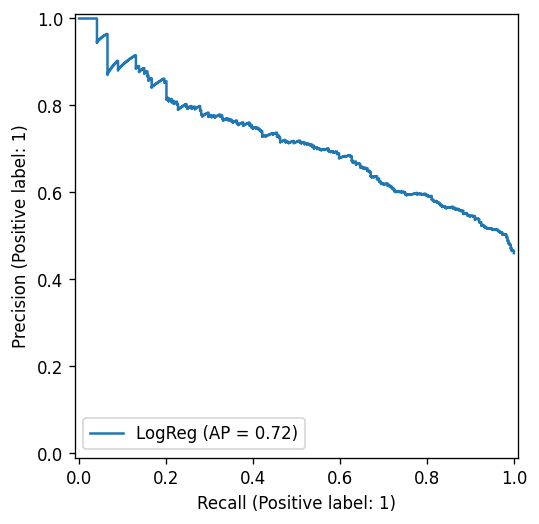

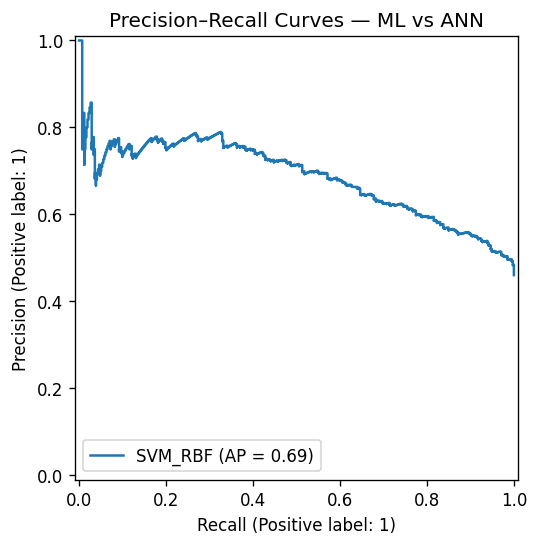

In [11]:
plt.figure(figsize=(7.5, 5.5))
for name in results_df.index:
    PrecisionRecallDisplay.from_predictions(y_test, artifacts[name]['prob'], name=name)
plt.title('Precision–Recall Curves — ML vs ANN')
plt.show()


### Interview mini‑Q (Plots)
1. Why do PR curves matter more when positives are rare?
2. What trade‑off exists between precision and recall?


## 🔟 Threshold Tuning (Optimize Recall)

Instead of default threshold 0.5, we tune thresholds to **maximize recall**,
optionally enforcing a minimum precision.


In [12]:
def best_threshold_for_recall(y_true, y_prob, min_precision=None):
    thresholds = np.linspace(0.0, 1.0, 501)
    best = {'threshold': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f = f1_score(y_true, y_pred, zero_division=0)
        if min_precision is not None and p < min_precision:
            continue
        if (r > best['recall']) or (r == best['recall'] and f > best['f1']):
            best = {'threshold': float(t), 'precision': float(p), 'recall': float(r), 'f1': float(f)}
    return best

best_model = results_df.index[0]
best_probs = artifacts[best_model]['prob']

print('Best model for tuning:', best_model)
print('Max recall (no constraint):', best_threshold_for_recall(y_test.values, best_probs))
print('Max recall with precision ≥ 0.30:', best_threshold_for_recall(y_test.values, best_probs, min_precision=0.30))


Best model for tuning: GradBoost
Max recall (no constraint): {'threshold': 0.038, 'precision': 0.46248600223964165, 'recall': 1.0, 'f1': 0.6324655436447167}
Max recall with precision ≥ 0.30: {'threshold': 0.038, 'precision': 0.46248600223964165, 'recall': 1.0, 'f1': 0.6324655436447167}


### Interview mini‑Q (Thresholds)
1. Why is threshold tuning a business decision?
2. When would you prioritize recall over precision?


## 1️⃣1️⃣ Feature Importance

We use two approaches:
- **Random Forest built‑in importance** (tree‑specific)
- **Permutation importance** (model‑agnostic)


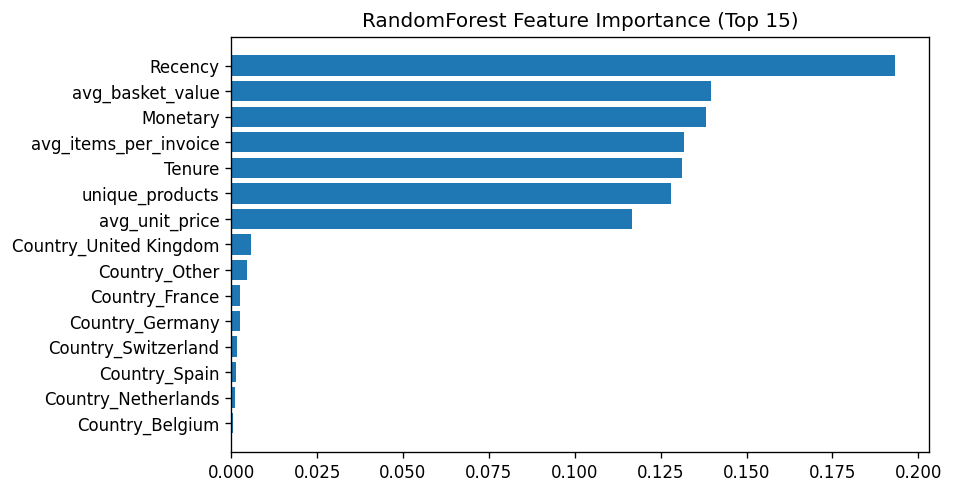

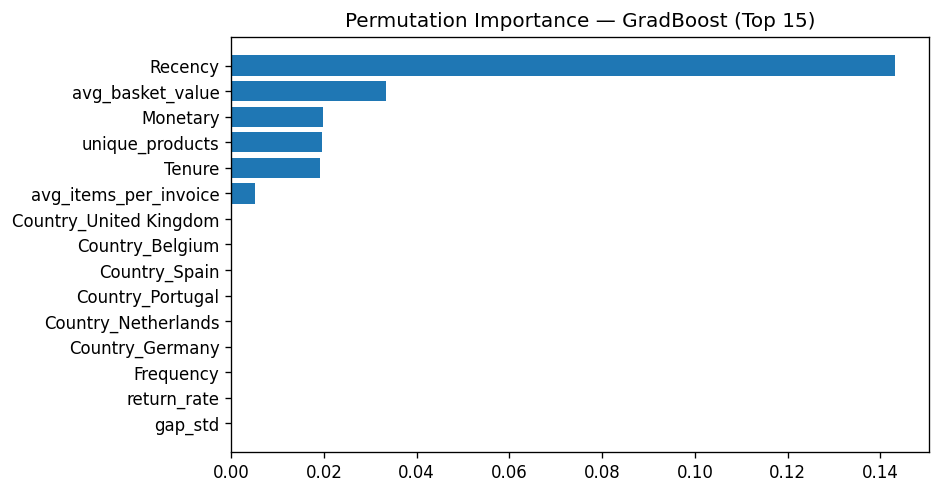

In [13]:
# A) Random Forest built-in importance
if 'RandomForest' in artifacts:
    rf_pipe = artifacts['RandomForest']['pipe']
    rf_model = rf_pipe.named_steps['model']
    feat_names = numeric_cols
    rf_imp = pd.Series(rf_model.feature_importances_, index=feat_names).sort_values(ascending=False)
    rf_imp.head(15)
    plt.figure(figsize=(7.5, 4.5))
    vals = rf_imp.head(15)[::-1]
    plt.barh(vals.index, vals.values)
    plt.title('RandomForest Feature Importance (Top 15)')
    plt.show()

# B) Permutation importance (best model)
best_pipe = artifacts[best_model]['pipe']
perm = permutation_importance(
    best_pipe, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring='roc_auc'
)
perm_imp = pd.Series(perm.importances_mean, index=numeric_cols).sort_values(ascending=False)
perm_imp.head(15)
plt.figure(figsize=(7.5, 4.5))
vals = perm_imp.head(15)[::-1]
plt.barh(vals.index, vals.values)
plt.title(f'Permutation Importance — {best_model} (Top 15)')
plt.show()


In [14]:
import json
import joblib
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


# =========================
# CONFIG
# =========================
DATA_PATH = Path(r"C:\Users\abhin\ai-systems-foundations\DeepLearningProject\data\processed\customer_features_v2.csv")
MODELS_DIR = Path(r"C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models")

TARGET = "is_churned"
RANDOM_STATE = 42

MODELS_DIR.mkdir(parents=True, exist_ok=True)


# =========================
# Utility: sanitize ANN RNG state before saving
# =========================
def sanitize_for_joblib(pipe: Pipeline) -> Pipeline:
    """
    Some sklearn models (especially MLPClassifier) may serialize a numpy RandomState / BitGenerator
    that breaks across numpy versions. This function removes those non-essential RNG objects.

    It does NOT change learned weights. It only removes internal RNG state.
    """
    if "model" not in pipe.named_steps:
        return pipe

    model = pipe.named_steps["model"]

    # For MLPClassifier: remove the internal RNG to avoid BitGenerator pickle issues
    if isinstance(model, MLPClassifier):
        # sklearn uses _random_state internally; safe to null it after training
        if hasattr(model, "_random_state"):
            model._random_state = None

        # Some versions store random_state as RandomState object; keep int seed instead
        model.random_state = RANDOM_STATE

    return pipe


# =========================
# 1) Load data
# =========================
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.astype(str).str.strip()
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

drop_cols = [c for c in ["CustomerID", "Customer ID"] if c in df.columns]
X = df.drop(columns=[TARGET] + drop_cols, errors="ignore")
y = df[TARGET]

feature_cols = X.columns.tolist()

print("✅ Loaded dataset")
print("✅ Features:", len(feature_cols))


# =========================
# 2) Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)


# =========================
# 3) Preprocess
# =========================
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), feature_cols)
    ],
    remainder="drop"
)


# =========================
# 4) Models
# =========================
models = {
    "LogReg": LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE),

    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    "ANN_MLP": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        alpha=0.001,
        batch_size=64,
        learning_rate_init=0.001,
        max_iter=600,
        early_stopping=True,
        random_state=RANDOM_STATE
    )
}


# =========================
# 5) Train + Save (SAFE)
# =========================
scores = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")

    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)

    # Sanitize before saving (important for ANN)
    pipe = sanitize_for_joblib(pipe)

    model_path = MODELS_DIR / f"{name}.joblib"
    joblib.dump(pipe, model_path)

    features_path = MODELS_DIR / f"{name}.features.json"
    with open(features_path, "w") as f:
        json.dump(feature_cols, f, indent=2)

    score = pipe.score(X_test, y_test)
    scores[name] = score

    print(f"✅ Saved: {model_path}")
    print(f"✅ Saved: {features_path}")
    print(f"📊 Test accuracy: {score:.4f}")


# =========================
# 6) Save best model + global feature schema
# =========================
best_model_name = max(scores, key=scores.get)
best_model_path = MODELS_DIR / f"{best_model_name}.joblib"

print(f"\n🏆 Best model (accuracy): {best_model_name}")

best_pipe = joblib.load(best_model_path)
joblib.dump(best_pipe, MODELS_DIR / "best_churn_model.joblib")

with open(MODELS_DIR / "model_features.json", "w") as f:
    json.dump(feature_cols, f, indent=2)

print("✅ Saved: best_churn_model.joblib")
print("✅ Saved: model_features.json")
print("\n🎉 Export complete!")


✅ Loaded dataset
✅ Features: 21

🚀 Training LogReg...
✅ Saved: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models\LogReg.joblib
✅ Saved: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models\LogReg.features.json
📊 Test accuracy: 0.6867

🚀 Training RandomForest...
✅ Saved: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models\RandomForest.joblib
✅ Saved: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models\RandomForest.features.json
📊 Test accuracy: 0.6711

🚀 Training ANN_MLP...
✅ Saved: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models\ANN_MLP.joblib
✅ Saved: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models\ANN_MLP.features.json
📊 Test accuracy: 0.6867

🏆 Best model (accuracy): LogReg
✅ Saved: best_churn_model.joblib
✅ Saved: model_features.json

🎉 Export complete!


In [ ]:
# #!/usr/bin/env python3
# import json
# import joblib
# from pathlib import Path

# import numpy as np
# import pandas as pd

# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier


# # =========================
# # CONFIG
# # =========================
# DATA_PATH = Path(
#     r"C:\Users\abhin\ai-systems-foundations\DeepLearningProject\data\processed\customer_features_v2.csv"
# )

# MODELS_DIR = Path(
#     r"C:\Users\abhin\ai-systems-foundations\DeepLearningProject\models"
# )

# TARGET = "is_churned"
# RANDOM_STATE = 42

# MODELS_DIR.mkdir(parents=True, exist_ok=True)


# # =========================
# # 1️ Load data
# # =========================
# df = pd.read_csv(DATA_PATH)
# df.columns = df.columns.astype(str).str.strip()

# df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

# # Drop ID columns
# drop_cols = [c for c in ["CustomerID", "Customer ID"] if c in df.columns]
# X = df.drop(columns=[TARGET] + drop_cols)
# y = df[TARGET]

# feature_cols = X.columns.tolist()

# print("✅ Loaded dataset")
# print("Features:", len(feature_cols))


# # =========================
# # 2️ Train / test split
# # =========================
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
# )


# # =========================
# # 3️⃣ Preprocessing
# # =========================
# preprocess = ColumnTransformer(
#     transformers=[
#         ("num", Pipeline([
#             ("imputer", SimpleImputer(strategy="median")),
#             ("scaler", StandardScaler())
#         ]), feature_cols)
#     ],
#     remainder="drop"
# )


# # =========================
# # 4️ Models to train & save
# # =========================
# models = {
#     "LogReg": LogisticRegression(
#         max_iter=3000,
#         class_weight="balanced",
#         random_state=RANDOM_STATE
#     ),

#     "RandomForest": RandomForestClassifier(
#         n_estimators=500,
#         class_weight="balanced_subsample",
#         random_state=RANDOM_STATE,
#         n_jobs=-1
#     ),

#     "ANN_MLP": MLPClassifier(
#         hidden_layer_sizes=(128, 64),
#         activation="relu",
#         alpha=0.001,
#         batch_size=64,
#         learning_rate_init=0.001,
#         max_iter=600,
#         early_stopping=True,
#         random_state=RANDOM_STATE
#     )
# }


# # =========================
# #  Train, save models + features
# # =========================
# scores = {}

# for name, model in models.items():
#     print(f"\n🚀 Training {name}...")

#     pipe = Pipeline([
#         ("prep", preprocess),
#         ("model", model)
#     ])

#     pipe.fit(X_train, y_train)

#     # Save model
#     model_path = MODELS_DIR / f"{name}.joblib"
#     joblib.dump(pipe, model_path)

#     # Save feature list
#     features_path = MODELS_DIR / f"{name}.features.json"
#     with open(features_path, "w") as f:
#         json.dump(feature_cols, f, indent=2)

#     score = pipe.score(X_test, y_test)
#     scores[name] = score

#     print(f"✅ Saved {model_path.name}")
#     print(f"✅ Saved {features_path.name}")
#     print(f"📊 Test accuracy: {score:.4f}")


# # =========================
# #Save BEST model (optional)
# # =========================
# best_model_name = max(scores, key=scores.get)
# best_model_path = MODELS_DIR / f"{best_model_name}.joblib"

# print(f"\n🏆 Best model based on accuracy: {best_model_name}")

# joblib.dump(joblib.load(best_model_path), MODELS_DIR / "best_churn_model.joblib")

# with open(MODELS_DIR / "model_features.json", "w") as f:
#     json.dump(feature_cols, f, indent=2)

# print("✅ Saved best_churn_model.joblib")
# print("✅ Saved model_features.json")

# print("\n🎉 Model export complete!")


✅ Loaded dataset
Features: 21

🚀 Training LogReg...
✅ Saved LogReg.joblib
✅ Saved LogReg.features.json
📊 Test accuracy: 0.6867

🚀 Training RandomForest...
✅ Saved RandomForest.joblib
✅ Saved RandomForest.features.json
📊 Test accuracy: 0.6711

🚀 Training ANN_MLP...
✅ Saved ANN_MLP.joblib
✅ Saved ANN_MLP.features.json
📊 Test accuracy: 0.6867

🏆 Best model based on accuracy: LogReg
✅ Saved best_churn_model.joblib
✅ Saved model_features.json

🎉 Model export complete!


### Interview mini‑Q (Feature Importance)
1. Why is permutation importance preferred for ANN?
2. What are limitations of tree‑based importances?
3. How do you validate feature importance stability?


# ✅ Final Interview Preparation

**Explain this project in one sentence:**  
“I built an end‑to‑end churn prediction pipeline comparing ML models and an ANN, evaluated them with ROC & PR curves, tuned thresholds for business goals, and explained predictions using feature importance.”

## Common interview questions
1. Why ROC‑AUC over accuracy?
2. How did you handle class imbalance?
3. How did you avoid data leakage?
4. Why does ANN need scaling?
5. How would you productionize this pipeline?
6. What monitoring would you add post‑deployment?
